In [4]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/SucroseCountdown/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

proj_file = "SucroseCD_projection.csv"
mean_file = "SucroseCD_mean_scores.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


FEATURE_LIST = ['X_power_1_2','X_coh_1_2','X_gc_1_2']
FEATURE_WEIGHT = [10,1,1]

import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

def get_3_net_aucs(s,y,y_group=None):
    
    auc_mean_list = []
    auc_stderr_list =[]
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        mean = np.mean([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"])
        stderr = np.std([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"]) / np.sqrt(len(auc_dict.keys()))
        
        auc_mean_list.append(mean)
        auc_stderr_list.append(stderr)
        
    return auc_mean_list, auc_stderr_list

def get_3_net_auc_dict(s,y,y_group=None):
    auc_dict_list = []
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        auc_dict_list.append(auc_dict)
        
    return auc_dict_list

In [2]:
num_before = 3
num_after = 4
files = os.listdir(DATA_PATH)
scd_pickle_files = [file for file in files if file.split(".")[-1] == "pkl"]
auc_list = []
mouse_list = []
mouse_snip_list = []
for file in scd_pickle_files:
    dictSC = pickle.load(open(DATA_PATH + file, "rb"))
    X = np.hstack([dictSC[key]*weight for key, weight in zip(["X_psd","X_coh","X_gc"],FEATURE_WEIGHT)])
    y = dictSC["y_countDown"]
    s = model.project(X)
    coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())
    s_agg = np.sum(s[:,:3] * coeffs,axis=1)
    mouse_auc = model.score(X,y.reshape(-1,1))
    print("{} AUC: {}".format(file.split("_")[0],mouse_auc))
    auc_list.append(mouse_auc)
    mouse_list.append(file.split("_")[0])
    

    mouse_snips = []
    mouse_ids = []
    for expDate in np.unique(dictSC["y_expDate_aw"]):

        expDate_mask = dictSC["y_expDate_aw"]==expDate
        expDate_pump_mask = np.logical_and(expDate_mask,dictSC["y_pump_allWindows"])
        pump_times = dictSC["y_time_aw"][expDate_pump_mask==1]

        expDate_mask_w = dictSC["y_expDate"]==expDate
        masked_time = dictSC["y_time"][expDate_mask_w==1]

        for pump_time in pump_times:
            pump_idx = np.where(masked_time==pump_time)[0].astype(int)
            if pump_idx.shape[0] < 1:
                continue
            else:
                pump_idx = pump_idx[0]


                if np.array_equal(np.arange(pump_time-num_before,pump_time+num_after),masked_time[pump_idx - num_before: pump_idx+num_after]):
                    mouse_snips.append(s_agg[pump_idx-num_before:pump_idx+num_after])


    mouse_mean_scores = np.mean(mouse_snips,axis=0).squeeze()
    mouse_snip_list.append(mouse_mean_scores)
    
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/work/mk423/SucroseCountdown/'

In [3]:
len(mouse_snips)

190

In [4]:
mean_auc = np.mean(auc_list)
std_err = np.std(auc_list) / np.sqrt(len(auc_list))
print("{:.3f} +/- {:.3f}".format(mean_auc,std_err))

0.539 +/- 0.026


### Plotting Network Score

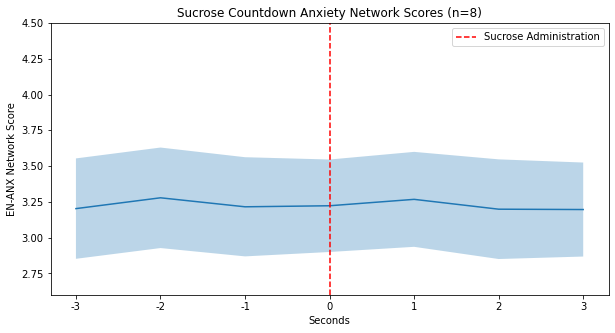

In [5]:
all_mouse_mean_score = np.mean(mouse_snip_list,axis=0)
all_mouse_sterr_score = np.std(mouse_snip_list,axis=0) / np.sqrt(8)
plt.figure(figsize=(10,5))
plt.plot(all_mouse_mean_score)
plt.fill_between(range(num_before + num_after),all_mouse_mean_score + all_mouse_sterr_score,all_mouse_mean_score - all_mouse_sterr_score,alpha=0.3)
plt.xticks(np.arange(num_before + num_after),np.arange(num_before + num_after) - num_before)
plt.ylim([2.6,4.5])
plt.axvline(num_before,color="red",linestyle="--",label="Sucrose Administration")
plt.legend()
plt.xlabel("Seconds")
plt.ylabel("EN-ANX Network Score")

plt.title("Sucrose Countdown Anxiety Network Scores (n=8)")
plt.savefig("/hpc/home/mk423/Anxiety/FullDataWork/Figures/SucroseCD_Network_Trace.svg")
plt.show()

### Comparing AUCs to FLX performance

In [6]:
from scipy.stats import ranksums

scd_aucs = auc_list
flx_aucs = [0.4102502200646685,0.6067541168223762,
            0.6708565853658537,0.6314347244280166,
            0.5610492452363276,0.6340186801104197]

stat,pval = ranksums(scd_aucs,flx_aucs)

print(stat,pval)

-1.2909944487358056 0.19670560245894686


### Event Aligned Code

In [6]:
LPNE_PATH = "/work/mk423/lpne-data-analysis/"
sys.path.append(LPNE_PATH)
import data_tools

In [7]:
X_psd, X_coh, X_gc, labels = data_tools.load_data("/work/mk423/Anxiety/sucroseCD_events.mat",feature_list=["power","coherence","granger"])

version saveFeatures_1.2 used to calcuate power features
version saveFeatures_1.2 used to calcuate coherence features


/work/mk423/lpne-data-analysis/data_tools.py:144: UserWarning: Raw Granger causality values loaded; if you want exponentiated or capped features, you must do that yourself
  warnings.warn("Raw Granger causality values loaded; if you want exponentiated or capped features, you must do that yourself")


version saveFeatures_1.2 used to calcuate granger features
Version preprocessData_1.0 of preprocessing used
Make sure feature versions listed above match those used for any other dataset in the same project


In [8]:
X = np.hstack((X_psd*10,X_coh,X_gc))
s = model.project(X)
y_frame = np.array(labels['windows']['frame'])
y_mouse = np.array(labels['windows']['mouse'])
y_expDate = np.array(labels['windows']['expDate'])

segs = []
segs_mouse = []
segs_expDate = []
segs_pumpTime = []
frames = [0]
for frame in np.unique(y_frame):
    if np.sum(y_frame==frame) == 10:
        if np.sum(np.abs(np.array(frames) - frame) < 1000*0) == 0:
            frame_mask = y_frame==frame
            
            if y_mouse[frame_mask==1][0] == "Mouse04394" and y_expDate[frame_mask==1][0] == "070320":
                continue
            else:
                segs.append(s[frame_mask==1])
                segs_mouse.append(y_mouse[frame_mask==1][0])
                segs_expDate.append(y_expDate[frame_mask==1][0])
                segs_pumpTime.append(frame)
                frames.append(frame)
        
segs = np.array(segs)
segs_mouse = np.array(segs_mouse)
segs_expDate = np.array(segs_expDate)
segs_pumpTime = np.array(segs_pumpTime)

mouse_means = []
mouse_id = []
for mouse in np.unique(segs_mouse):
    mouse_mask = segs_mouse==mouse
    temp_mean = np.mean(segs[mouse_mask==1,:,:],axis=0)
    mouse_means.append(temp_mean)
    mouse_id.append(mouse)
    
mouse_means = np.array(mouse_means)

print(segs.shape)

(2245, 10, 30)


In [32]:
comp_s = model.classifier[0].weight[0].detach().cpu().numpy()
segs_agg = segs[:,:,:3] @ comp_s

print(segs_agg.shape)

eventsArray = np.hstack([segs_mouse.reshape(-1,1).astype(object),
                        segs_expDate.reshape(-1,1).astype(object),
                        segs_pumpTime.reshape(-1,1).astype(object),
                        segs_agg])

df = pd.DataFrame(eventsArray)
df.columns = ["mouse","expDate","pumpTime (ms)", "-5","-4","-3","-2","-1","0","1","2","3","4"]
df.head()

temp_means = []
temp_mice = []
for mouse in np.unique(df.mouse):
    mean = np.nanmean(df[np.array(df.mouse).astype(str)==mouse][["-5","-4","-3","-2","-1","0","1","2","3","4"]].values,axis=0)
    temp_means.append(mean)
    temp_mice.append(mouse)
    
df_means = pd.DataFrame(np.hstack([np.array(temp_mice).astype(object).reshape(-1,1),np.vstack(temp_means).astype(object)]))
df_means.to_csv(PROJECT_PATH + "SucroseCD_5b5a_net_{}_means.csv".format(i+1))
   
df.to_csv(PROJECT_PATH + "SucroseCD_5b5a.csv")
df_means.to_csv(PROJECT_PATH + "SucroseCD_5b5a_means.csv".format(i+1))


for i in range(3):

    eventsArray = np.hstack([segs_mouse.reshape(-1,1).astype(object),
                            segs_expDate.reshape(-1,1).astype(object),
                            segs_pumpTime.reshape(-1,1).astype(object),
                            segs[:,:,i]])

    df = pd.DataFrame(eventsArray)
    df.columns = ["mouse","expDate","pumpTime (ms)", "-5","-4","-3","-2","-1","0","1","2","3","4"]
    

    df.to_csv(PROJECT_PATH + "SucroseCD_5b5a_net_{}.csv".format(i+1))
    
    temp_means = []
    temp_mice = []
    for mouse in np.unique(df.mouse):
        mean = np.nanmean(df[np.array(df.mouse).astype(str)==mouse][["-5","-4","-3","-2","-1","0","1","2","3","4"]].values,axis=0)
        temp_means.append(mean)
        temp_mice.append(mouse)
        
    df_means = pd.DataFrame(np.hstack([np.array(temp_mice).astype(object).reshape(-1,1),np.vstack(temp_means).astype(object)]))
    df_means.to_csv(PROJECT_PATH + "SucroseCD_5b5a_net_{}_means.csv".format(i+1))
   
df.head()

(2245, 10)


,mouse,expDate,pumpTime (ms),-5,-4,-3,-2,-1,0,1,2,3,4
0,Mouse04395,063020,50353,0.049662,0.042654,0.069905,0.008511,0.067456,0.013892,0.060629,0.042375,0.103242,0.013136
1,Mouse04391,061320,51529,0.019975,0.083915,0.019211,0.022284,0.005981,0.044725,0.002958,0.040248,0.025408,0.020571
2,Mouse04393,053120,53740,0.062076,0.065075,0.027933,0.046829,0.026761,0.0397,0.031759,0.070558,0.07552,0.005859
3,Mouse04395,062820,53929,0.020747,0.021448,0.008141,0.029459,0.027918,0.061562,0.052078,0.06389,0.018901,0.013652
4,Mouse04395,062520,59612,0.066894,0.042929,0.029189,0.041216,0.070883,0.015491,0.078175,0.044709,0.012541,0.125959


In [30]:
df_means

,0,1,2,3,4,5,6,7,8,9,10
0,Mouse04382,0.027358,0.032614,0.031981,0.035688,0.039655,0.032964,0.033188,0.02313,0.032595,0.027647
1,Mouse04383,0.015925,0.023553,0.023125,0.026151,0.026234,0.02236,0.028183,0.023555,0.021928,0.023698
2,Mouse04384,0.033726,0.034643,0.032655,0.036172,0.035452,0.038712,0.033909,0.032968,0.027822,0.033627
3,Mouse04385,0.007336,0.023396,0.019621,0.027104,0.033721,0.021942,0.01697,0.013576,0.028305,0.012537
4,Mouse04391,0.03602,0.031691,0.032215,0.031199,0.033183,0.030053,0.028169,0.024007,0.028598,0.031388
5,Mouse04392,0.024236,0.017386,0.015279,0.010328,0.014984,0.017655,0.009571,0.00758,0.02732,0.016867
6,Mouse04393,0.046698,0.043979,0.044219,0.048417,0.048245,0.042919,0.049915,0.043734,0.031236,0.038017
7,Mouse04394,0.042851,0.04616,0.052942,0.057884,0.057492,0.047816,0.051353,0.044037,0.048041,0.050604
8,Mouse04395,0.030343,0.027531,0.029093,0.03248,0.03716,0.028829,0.038994,0.030139,0.027203,0.028916


In [23]:
for mouse in np.unique(df.mouse):
    mean = np.nanmean(df[np.array(df.mouse).astype(str)==mouse][["-5","-4","-3","-2","-1","0","1","2","3","4"]].values,axis=0)
    print(mouse,mean)

Mouse04382 [0.027357600851577114 0.032614267113703216 0.0319811554456299
 0.03568833703386851 0.039655235976996744 0.032964255173944614
 0.0331881439038129 0.02312980810264972 0.0325949300842529
 0.027647238087163052]
Mouse04383 [0.015925013916598108 0.02355279880654883 0.023125179521327477
 0.026150566707566426 0.02623402710236061 0.022359937883831116
 0.02818270976051071 0.023554849990862978 0.021928188190836202
 0.023697961309116042]
Mouse04384 [0.03372614290483619 0.034642804738435125 0.03265494960676112
 0.03617174507590101 0.03545178717237233 0.0387117507334773
 0.03390898565100165 0.03296764691558343 0.027821591441684952
 0.03362653366694736]
Mouse04385 [0.00733611515412728 0.02339550418158372 0.019621084133783977
 0.027104085311293602 0.03372085575635234 0.02194235473871231
 0.016970061386624973 0.013576345207790533 0.028305359184741974
 0.012536623359968265]
Mouse04391 [0.036020382399759625 0.03169071763352947 0.03221520249089257
 0.03119912072035827 0.033182688297146296 0.030

In [11]:
for mouse in np.unique(y_mouse):
    for expDate in np.unique(y_expDate):
        
        mouse_mask = y_mouse == mouse
        expDate_mask = y_expDate == expDate
        mask = np.logical_and(mouse_mask,expDate_mask)
        
        

        
        if np.sum(mask) > 0:
            temp_frames = y_frame[mask==1]
            min_dif = 1000000
            for idx,frame in enumerate(np.unique(temp_frames)):
                if idx > 1:
                    diff = np.unique(temp_frames)[idx] - np.unique(temp_frames)[idx-1]

                    if diff < min_dif:
                        min_dif = diff

            print(mouse,"Date:",expDate,"Smallest pump offset in seconds: ",min_dif/1000)
            

Mouse04381 Date: 070420 Smallest pump offset in seconds:  22.189
Mouse04382 Date: 062320 Smallest pump offset in seconds:  10.341
Mouse04382 Date: 062420 Smallest pump offset in seconds:  10.586
Mouse04382 Date: 062520 Smallest pump offset in seconds:  9.658
Mouse04382 Date: 062620 Smallest pump offset in seconds:  9.791
Mouse04382 Date: 062720 Smallest pump offset in seconds:  11.322
Mouse04383 Date: 062420 Smallest pump offset in seconds:  8.56
Mouse04383 Date: 062520 Smallest pump offset in seconds:  9.454
Mouse04383 Date: 062620 Smallest pump offset in seconds:  9.785
Mouse04383 Date: 062720 Smallest pump offset in seconds:  9.27
Mouse04384 Date: 061920 Smallest pump offset in seconds:  7.052
Mouse04384 Date: 062020 Smallest pump offset in seconds:  6.708
Mouse04384 Date: 071420 Smallest pump offset in seconds:  10.87
Mouse04384 Date: 071820 Smallest pump offset in seconds:  9.324
Mouse04384 Date: 071920 Smallest pump offset in seconds:  9.96
Mouse04385 Date: 062120 Smallest pump o

In [41]:
mouse_means.shape

(9, 10, 30)

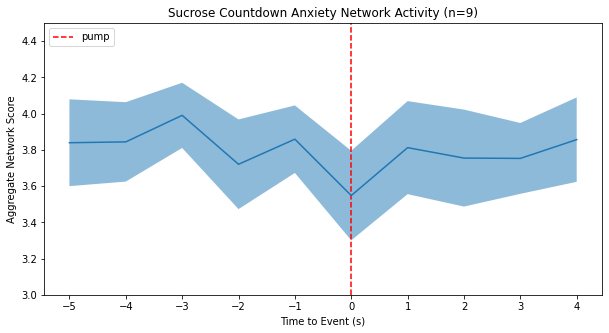

In [64]:
plt.figure(figsize=(10, 5))
comp_s = model.classifier[0].weight[0].detach().cpu().numpy()
#for i in [1]:
net = "comp"
mean = np.mean(mouse_means[:,:,:3] @ comp_s,axis=0)
stderr = np.std(mouse_means[:,:,:3] @ comp_s,axis=0) / np.sqrt(mouse_means.shape[0])
plt.axvline(0,linestyle="dashed",color="red",label="pump")
plt.plot(np.arange(10) - 5,mean)#label="network {}".format(net))
plt.fill_between(np.arange(10) - 5, mean + stderr, mean - stderr,alpha=0.5)
#plt.fill_between(np.arange(4) -3, 0,5,alpha=0.2,color="red",label="pre-pump")
#plt.fill_between(np.arange(3), 0,5,alpha=0.2,color="green",label="post-pump")
plt.title("Sucrose Countdown Anxiety Network Activity (n={})".format(len(mouse_id)))
plt.ylim([3,4.5])
plt.xticks(np.arange(10)-5)
#plt.xlim([-5,5])
plt.legend(loc="upper left")
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event (s)")
plt.show()

In [70]:
plt.figure(figsize=(10, 5))
comp_s = model.classifier[0].weight[0].detach().cpu().numpy()
for i in [0,1,2]:
    net = i
    mean = np.mean(mouse_means[:,:,net],axis=0)
    stderr = np.std(mouse_means[:,:,net],axis=0) / np.sqrt(mouse_means.shape[0])
    plt.plot(np.arange(6) -3,mean,label="network {}".format(net+1))
    plt.fill_between(np.arange(6) -3, mean + stderr, mean - stderr,alpha=0.5)
plt.fill_between(np.arange(4) -3, 0,5,alpha=0.2,color="red",label="pre-pump")
plt.fill_between(np.arange(3), 0,5,alpha=0.2,color="green",label="post-pump")
plt.title("Sucrose Countdown Anxiety Network Activity (n={})".format(len(mouse_id)))
plt.ylim([0.025,0.3])
plt.xlim([-2,2])
plt.legend(loc="upper left")
plt.ylabel("Individual Network Score")
plt.xlabel("Time to Event (s)")
plt.show()

array(['Mouse04382', 'Mouse04383', 'Mouse04384', 'Mouse04385',
       'Mouse04391', 'Mouse04392', 'Mouse04393', 'Mouse04394',
       'Mouse04395'], dtype='<U10')

In [82]:
np.unique(labels['windows']['mouse'])

array(['Mouse04381', 'Mouse04382', 'Mouse04383', 'Mouse04384',
       'Mouse04385', 'Mouse04391', 'Mouse04392', 'Mouse04393',
       'Mouse04394', 'Mouse04395'], dtype='<U10')

In [84]:
np.unique(labels['windows']['expDate'])

array(['053020', '053120', '060120', '060920', '061020', '061120',
       '061220', '061320', '061420', '061920', '062020', '062120',
       '062220', '062320', '062420', '062520', '062620', '062720',
       '062820', '062920', '063020', '070220', '070320', '070420',
       '071420', '071820', '071920'], dtype='<U6')

In [88]:
for mouse in np.unique(labels['windows']['mouse']):
    mouse_mask = y_mouse==mouse
    
    print(mouse,np.unique(np.array(labels['windows']['expDate'])[mouse_mask==1]))

Mouse04381 ['070420']
Mouse04382 ['062320' '062420' '062520' '062620' '062720']
Mouse04383 ['062420' '062520' '062620' '062720']
Mouse04384 ['061920' '062020' '071420' '071820' '071920']
Mouse04385 ['062120' '062720']
Mouse04391 ['060920' '061120' '061220' '061320' '061420' '062620']
Mouse04392 ['061020' '061220']
Mouse04393 ['053020' '053120' '060120']
Mouse04394 ['062220' '062320' '062420' '062520' '062620' '062720' '070220' '070320']
Mouse04395 ['062520' '062620' '062720' '062820' '062920' '063020']


In [87]:
np.array(labels['windows']['expDate'])[mouse_mask==1]

array(['062520', '062520', '062520', ..., '063020', '063020', '063020'],
      dtype='<U6')